In [70]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from sklearn.metrics import r2_score
from sklearn import preprocessing
#import scipy.io as sio

from models import AE
from models import DNN
import numpy as np
import pandas as pd

In [71]:
from scipy.stats import pearsonr

# Parameters

In [72]:
# Define parameters
epochs = 500 #200,500,1000
dim_au_in = 20049
dim_au_out = 512 #8, 16, 32, 64, 128, 256,512
dim_dnn_in = dim_au_out
dim_dnn_out=1

# Import data

In [73]:
data_r=pd.read_csv('data/GDSCexpression.csv',index_col=0)
label_r=pd.read_csv('data/GDSClabel.csv',index_col=0)

In [74]:
label_r=label_r.fillna(1)

# Your is gene-cell, mine is cell-gene

In [75]:
len(set(data_r.index))

727

In [76]:
data = data_r
label = label_r.iloc[:,10]
scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
data = scaler.fit_transform(data)

In [77]:
print(np.std(data))
print(np.mean(data))

0.9999999999999997
6.316789844568889e-19


In [78]:
data.shape

(789, 11833)

In [79]:
label_r.shape

(789, 139)

# Split test train

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [81]:
print(data.shape)
print(label.shape)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(789, 11833)
(789,)
(631, 11833) (631,)
(158, 11833) (158,)


In [82]:
print(X_train.max())
print(X_train.min())

23.78951596267762
-17.277718272630676


In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
torch.cuda.set_device(device)

cuda:0


# Add all data to AE

In [84]:
trainData = torch.FloatTensor(X_train).to(device)
testData = torch.FloatTensor(X_test).to(device)
y = torch.FloatTensor(Y_train.values).to(device)
allData = torch.FloatTensor(data).to(device)

# construct TensorDataset
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
all_dataset = TensorDataset(allData, allData)

trainDataLoader1 = DataLoader(dataset=train_dataset, batch_size=200, shuffle=False)
trainDataLoaderall = DataLoader(dataset=all_dataset, batch_size=200, shuffle=True)

# The model

In [85]:
# Initialization

#autoencoder = AE(dim=train_dataset.shape[1]).to(device)
autoencoder = AE(dim_au_in = X_train.shape[1],dim_au_out=dim_au_out).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
#loss1
loss_func = nn.SmoothL1Loss().to(device)
#loss2
#loss_func = nn.BCELoss()
loss_train = np.zeros((epochs, 1))

In [86]:
# Train autoencoder

for epoch in range(epochs):
    # 不需要label，所以用一个占位符"_"代替
    for batchidx, (x, _) in enumerate(trainDataLoaderall):
        x.requires_grad_(True)
        # encode and decode 
        decoded, encoded = autoencoder(x)
        # compute loss
        print(encoded.shape, decoded.shape)
        loss = loss_func(decoded, x)      
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
           
    loss_train[epoch,0] = loss.item()  
    print('Epoch: %04d, Training loss=%.8f' %
          (epoch+1, loss.item()))

torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0001, Training loss=0.37845567
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0002, Training loss=0.37417948
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0003, Training loss=0.37675849
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0004, Training loss=0.37448874
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Siz

Epoch: 0037, Training loss=0.35037434
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0038, Training loss=0.35043821
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0039, Training loss=0.34224981
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0040, Training loss=0.34003708
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0041, Training loss=0.34447372
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0074, Training loss=0.28421766
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0075, Training loss=0.28919125
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0076, Training loss=0.28766134
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0077, Training loss=0.28163621
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0078, Training loss=0.28192759
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0110, Training loss=0.27803990
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0111, Training loss=0.27449638
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0112, Training loss=0.27499014
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0113, Training loss=0.28001347
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0114, Training loss=0.27840665
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0147, Training loss=0.26869822
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0148, Training loss=0.27362922
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0149, Training loss=0.27059832
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0150, Training loss=0.27522773
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0151, Training loss=0.27255723
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0184, Training loss=0.27096280
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0185, Training loss=0.26798484
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0186, Training loss=0.27404717
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0187, Training loss=0.26777554
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0188, Training loss=0.26911339
torch.Size([200, 512]) torch.Size([200, 11

torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0220, Training loss=0.26406708
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0221, Training loss=0.26315081
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0222, Training loss=0.26758355
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0223, Training loss=0.26389465
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0224, Training loss=0.269

Epoch: 0257, Training loss=0.26078066
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0258, Training loss=0.26416236
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0259, Training loss=0.26325715
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0260, Training loss=0.26501170
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0261, Training loss=0.26000199
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0294, Training loss=0.25680837
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0295, Training loss=0.26346919
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0296, Training loss=0.26133499
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0297, Training loss=0.26076898
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0298, Training loss=0.26089776
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0330, Training loss=0.25664932
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0331, Training loss=0.25547338
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0332, Training loss=0.26060957
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0333, Training loss=0.25850952
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0334, Training loss=0.25676405
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0367, Training loss=0.25577727
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0368, Training loss=0.25824898
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0369, Training loss=0.25575188
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0370, Training loss=0.25518274
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0371, Training loss=0.25672358
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0403, Training loss=0.25258747
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0404, Training loss=0.25433484
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0405, Training loss=0.25533438
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0406, Training loss=0.25297442
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0407, Training loss=0.25386095
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0440, Training loss=0.24949965
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0441, Training loss=0.25817943
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0442, Training loss=0.25549954
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0443, Training loss=0.25659952
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0444, Training loss=0.24831870
torch.Size([200, 512]) torch.Size([200, 11

Epoch: 0477, Training loss=0.25295240
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0478, Training loss=0.24937364
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0479, Training loss=0.25120503
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0480, Training loss=0.25301781
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([200, 512]) torch.Size([200, 11833])
torch.Size([189, 512]) torch.Size([189, 11833])
Epoch: 0481, Training loss=0.25151235
torch.Size([200, 512]) torch.Size([200, 11

In [87]:
torch.save(autoencoder.state_dict(), 'saved/models/AE_GDSC.pkl')

In [88]:
# extract features
_, encodedTrainData = autoencoder(trainData)
featureTensor = encodedTrainData.double()
feature = featureTensor.detach().cpu().numpy()

In [89]:
print(feature.shape)

(631, 512)


In [90]:
feature

array([[ -3.98830223, -14.46842289,  11.41365528, ...,  -9.24433613,
          3.9695642 ,  12.58987141],
       [-11.73050022,  -0.86351913,  -1.08967912, ...,  15.4855442 ,
         -6.06346178, -34.49357986],
       [  1.59288394,  25.82977676,  -7.95423126, ...,  18.5807991 ,
         -1.46764755,  14.93826675],
       ...,
       [ -3.00393653, -12.83430099,  -1.45899022, ...,   0.44991681,
         -0.48832205,  14.80224895],
       [ 11.41576099,   3.00179625,  14.86866474, ...,  -3.67698646,
         -7.11067963,   7.3389039 ],
       [-22.35505295,  -0.05884793,  -8.42875862, ...,   8.44301128,
         -1.06642449, -12.4538517 ]])

In [91]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(feature, Y_train.values)

Lasso(alpha=0.1)

In [92]:
_,testFeature = autoencoder(testData)
lasso = clf.predict(testFeature.detach().cpu().numpy())

In [93]:
r2_score(lasso,Y_test)

-3.107482739562604

In [94]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feature)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 631 samples in 0.030s...
[t-SNE] Computed neighbors for 631 samples in 0.267s...
[t-SNE] Computed conditional probabilities for sample 631 / 631
[t-SNE] Mean sigma: 114.791064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.070099
[t-SNE] KL divergence after 300 iterations: 1.423183


In [95]:
tsne_results

array([[  6.3864455,  -9.126111 ],
       [-10.78426  ,  -3.0034292],
       [ -5.8190293,   1.8749901],
       ...,
       [  1.2086612,  -3.6844873],
       [ -3.5691628,   1.2370542],
       [ -2.0948431,  14.303509 ]], dtype=float32)

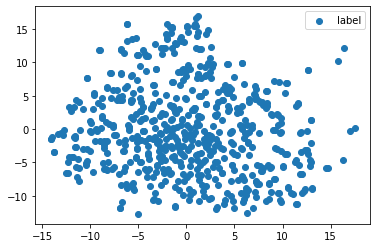

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], label="label")
plt.legend()
plt.savefig("saved/figures/tsne_ae_gdsc.png")

In [98]:
EPOCH = 500

In [99]:
# Load data
# data type conversion
B_feature = torch.FloatTensor(feature).to(device)
y = torch.FloatTensor(Y_train.values).to(device)
# construct TensorDataset
b_data = TensorDataset(B_feature, y)
trainDataLoader2 = DataLoader(dataset=b_data, batch_size=200, shuffle=False)

In [100]:
b_data.tensors

(tensor([[ -3.9883, -14.4684,  11.4137,  ...,  -9.2443,   3.9696,  12.5899],
         [-11.7305,  -0.8635,  -1.0897,  ...,  15.4855,  -6.0635, -34.4936],
         [  1.5929,  25.8298,  -7.9542,  ...,  18.5808,  -1.4676,  14.9383],
         ...,
         [ -3.0039, -12.8343,  -1.4590,  ...,   0.4499,  -0.4883,  14.8022],
         [ 11.4158,   3.0018,  14.8687,  ...,  -3.6770,  -7.1107,   7.3389],
         [-22.3551,  -0.0588,  -8.4288,  ...,   8.4430,  -1.0664, -12.4539]],
        device='cuda:0'),
 tensor([4.1360e-03, 2.4651e-01, 1.0000e+00, 1.6831e-01, 2.4553e-01, 4.5574e-02,
         5.6766e-01, 6.5160e-03, 5.1101e-02, 1.0000e+00, 1.0000e+00, 1.3382e-01,
         8.5730e-03, 2.0783e-02, 7.1891e-02, 2.6463e-02, 2.0267e-01, 1.6792e-01,
         2.2742e-01, 5.1173e-01, 5.5870e-02, 9.3305e-02, 3.9400e-03, 9.9018e-02,
         1.0000e+00, 7.3892e-02, 1.1134e-02, 8.2544e-02, 1.1754e-02, 1.4302e-01,
         1.0000e+00, 1.0000e+00, 2.4001e-02, 3.9460e-03, 7.5210e-03, 4.9375e-01,
         7.

In [101]:
b_data

In [102]:
dim_dnn_in

512

In [111]:
# Initialization DNN model

predictor = DNN(dim_dnn_in, dim_dnn_out).to(device)
optimizer = optim.Adam(predictor.parameters(), lr=1e-3,betas=(0.9,0.99))
#loss1-softmax
loss_func = nn.MSELoss().to(device)
#loss2-sigmoid
#loss_func = nn.BCELoss().to(device)
#loss3-sigmoid
#loss_func = nn.CrossEntropyLoss()

#criterion = torch.nn.MSELoss(size_average=True)
#criterion = torch.nn.BCELoss(size_average=True) # Defined loss function
#optimizer = optim.Adm(model.parameters(), lr=0.01) # Defined optimizer
loss_train = np.zeros((epochs, 1))

In [112]:
# train model
for epoch in range(EPOCH):
    print('Epoch: ',epoch)
    for step,(batch_x,batch_y) in enumerate(trainDataLoader2):
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
        # predict label
        output = predictor(b_x)
        # b_y=F.sigmoid(b_y) 
        
        #print
        #print(output)
        #print(b_y)
        # compute loss
        loss = loss_func(output,b_y)
        #loss = criterion(output, b_y)
        
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train[epoch,0] = loss.item()  
    print('Epoch: %04d, Training loss=%.8f' %
          (epoch+1, loss.item())) 

# Save model
torch.save(predictor.state_dict(), 'saved/models/DNN_GDSC.pkl')

Epoch:  0
Epoch: 0001, Training loss=0.14073600
Epoch:  1
Epoch: 0002, Training loss=0.14142042
Epoch:  2
Epoch: 0003, Training loss=0.14093786
Epoch:  3
Epoch: 0004, Training loss=0.13917321
Epoch:  4
Epoch: 0005, Training loss=0.13617325
Epoch:  5
Epoch: 0006, Training loss=0.14401031
Epoch:  6
Epoch: 0007, Training loss=0.13115421
Epoch:  7
Epoch: 0008, Training loss=0.12830086
Epoch:  8
Epoch: 0009, Training loss=0.11829123
Epoch:  9
Epoch: 0010, Training loss=0.11946681
Epoch:  10
Epoch: 0011, Training loss=0.11076292
Epoch:  11
Epoch: 0012, Training loss=0.10806186

D:\anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch:  12
Epoch: 0013, Training loss=0.10718475
Epoch:  13
Epoch: 0014, Training loss=0.10543577
Epoch:  14
Epoch: 0015, Training loss=0.10517173
Epoch:  15
Epoch: 0016, Training loss=0.10508906
Epoch:  16
Epoch: 0017, Training loss=0.10479159
Epoch:  17
Epoch: 0018, Training loss=0.10460429
Epoch:  18
Epoch: 0019, Training loss=0.10460255
Epoch:  19
Epoch: 0020, Training loss=0.10449547
Epoch:  20
Epoch: 0021, Training loss=0.10445882
Epoch:  21
Epoch: 0022, Training loss=0.10449649
Epoch:  22
Epoch: 0023, Training loss=0.10448916
Epoch:  23
Epoch: 0024, Training loss=0.10443692
Epoch:  24
Epoch: 0025, Training loss=0.10450164
Epoch:  25
Epoch: 0026, Training loss=0.10444888
Epoch:  26
Epoch: 0027, Training loss=0.10447725
Epoch:  27
Epoch: 0028, Training loss=0.10443346
Epoch:  28
Epoch: 0029, Training loss=0.10448634
Epoch:  29
Epoch: 0030, Training loss=0.10442650
Epoch:  30
Epoch: 0031, Training loss=0.10449669
Epoch:  31
Epoch: 0032, Training loss=0.10444964
Epoch:  32
Epoch: 0

Epoch:  180
Epoch: 0181, Training loss=0.10494240
Epoch:  181
Epoch: 0182, Training loss=0.10447871
Epoch:  182
Epoch: 0183, Training loss=0.10471171
Epoch:  183
Epoch: 0184, Training loss=0.10476775
Epoch:  184
Epoch: 0185, Training loss=0.10451405
Epoch:  185
Epoch: 0186, Training loss=0.10450434
Epoch:  186
Epoch: 0187, Training loss=0.10463460
Epoch:  187
Epoch: 0188, Training loss=0.10465564
Epoch:  188
Epoch: 0189, Training loss=0.10450678
Epoch:  189
Epoch: 0190, Training loss=0.10456882
Epoch:  190
Epoch: 0191, Training loss=0.10479669
Epoch:  191
Epoch: 0192, Training loss=0.10459951
Epoch:  192
Epoch: 0193, Training loss=0.10450009
Epoch:  193
Epoch: 0194, Training loss=0.10478222
Epoch:  194
Epoch: 0195, Training loss=0.10467076
Epoch:  195
Epoch: 0196, Training loss=0.10445446
Epoch:  196
Epoch: 0197, Training loss=0.10460965
Epoch:  197
Epoch: 0198, Training loss=0.10465343
Epoch:  198
Epoch: 0199, Training loss=0.10448022
Epoch:  199
Epoch: 0200, Training loss=0.10446742


Epoch: 0344, Training loss=0.10441911
Epoch:  344
Epoch: 0345, Training loss=0.10443647
Epoch:  345
Epoch: 0346, Training loss=0.10443545
Epoch:  346
Epoch: 0347, Training loss=0.10441904
Epoch:  347
Epoch: 0348, Training loss=0.10443515
Epoch:  348
Epoch: 0349, Training loss=0.10443678
Epoch:  349
Epoch: 0350, Training loss=0.10441985
Epoch:  350
Epoch: 0351, Training loss=0.10445715
Epoch:  351
Epoch: 0352, Training loss=0.10443637
Epoch:  352
Epoch: 0353, Training loss=0.10445099
Epoch:  353
Epoch: 0354, Training loss=0.10453214
Epoch:  354
Epoch: 0355, Training loss=0.10442746
Epoch:  355
Epoch: 0356, Training loss=0.10468252
Epoch:  356
Epoch: 0357, Training loss=0.10459860
Epoch:  357
Epoch: 0358, Training loss=0.10451577
Epoch:  358
Epoch: 0359, Training loss=0.10484159
Epoch:  359
Epoch: 0360, Training loss=0.10456555
Epoch:  360
Epoch: 0361, Training loss=0.10447305
Epoch:  361
Epoch: 0362, Training loss=0.10459330
Epoch:  362
Epoch: 0363, Training loss=0.10462384
Epoch:  363


In [105]:
# Get tesing feature
_,testFeature = autoencoder(testData)

In [106]:
testpredict = predictor(testFeature)

In [107]:
testpredict

tensor([[0.2343],
        [0.2168],
        [0.2243],
        [0.2337],
        [0.2166],
        [0.2663],
        [0.2910],
        [0.2743],
        [0.2034],
        [0.2739],
        [0.2607],
        [0.2710],
        [0.2828],
        [0.2410],
        [0.1940],
        [0.2478],
        [0.2325],
        [0.2811],
        [0.2589],
        [0.2358],
        [0.2513],
        [0.2742],
        [0.1638],
        [0.2183],
        [0.1812],
        [0.2537],
        [0.2488],
        [0.2066],
        [0.0644],
        [0.2257],
        [0.2081],
        [0.1899],
        [0.2967],
        [0.2300],
        [0.2832],
        [0.2550],
        [0.2008],
        [0.2838],
        [0.2039],
        [0.2412],
        [0.2903],
        [0.2678],
        [0.2008],
        [0.2573],
        [0.2536],
        [0.2891],
        [0.1939],
        [0.2167],
        [0.2740],
        [0.2599],
        [0.2401],
        [0.2867],
        [0.2378],
        [0.2719],
        [0.2295],
        [0

In [108]:
from sklearn.metrics import mean_squared_error

In [109]:
r2_score(testpredict.detach().cpu().numpy(),Y_test)

-79.57991528596291

In [110]:
mean_squared_error(testpredict.detach().cpu().numpy(),Y_test)

0.13058245534334187